[2024-07-26 Fiddler](https://thefiddler.substack.com/p/can-you-even-the-odds)
====================
Let $w$ be your probability of winning when it's your turn to roll.  Consider the AB|AB|AB order of play.

Let $p = 1/6$ be the probability of winning a roll.

In [1]:
%display latex
w, p = var('w p')
eqn1 = w == p + (1-p)*(1-w)
eqn1

w == (p - 1)*(w - 1) + p

In [2]:
solve(eqn1, w)

[w == -1/(p - 2)]

In [3]:
numerical_approx(solve(eqn1,w)[0].rhs()(p=1/6))

0.545454545454545

So player A will win approximately 54.55% of the time.

Now consider the AB|BA|AB order of play.  Consider what happens if the first roll does not win.

In [4]:
eqn2 = w == p + (1-p)*(p + (1-p)*(1-w))
eqn2

w == -((p - 1)*(w - 1) + p)*(p - 1) + p

In [5]:
solve(eqn2, w)

[w == (1/(p^2 - 2*p + 2))]

Now, add in the first roll.

In [6]:
w_after_first_roll = solve(eqn2, w)[0].rhs()
w_abba = p + (1-p)*(1-w_after_first_roll)
w_abba.simplify_full()

(p^2 - p + 1)/(p^2 - 2*p + 2)

In [7]:
numerical_approx(w_abba(p=1/6))

0.508196721311475

So player A will win approximately 50.82% of the time, which is fairer than AB|AB|AB.

[Simulations](20240726.go) agree:

    $ go run 20240726.go
    AB 5454278/10000000 0.545428
    ABBA 5083593/10000000 0.508359
    Thue-Morse 5016187/10000000 0.501619
    Round 1: A
    Round 2: B
    Round 3: BA
    Round 4: BAAB
    Round 5: BAABABBA
    Round 6: BAABABBAABBABAAB

Extra credit
------------

Let $q = 1-p = 5/6$.

In [8]:
q = var('q')

Let $A(n)$ be player A's probability of winning by round $n$, and $W(n)$ be player A's probability of winning in round $n$.

Let round 0 be A, round 1 be B, round 2 be BA, etc.  The number of rolls in round $n$ where $n > 0$ is $2^{n-1}$, so the
probability that neither player wins in the round is $q^{2^{n-1}}$, and the probability of getting to round $n$ without
a winner is $q^{2^{n-1}}$.

$$ A(n) = W(0) + \sum_{l=1}^n q^{2^{l-1}}W(l) $$

And $A(\infty)$ is player A's total probability of winning.
For $n > 1$, the first half of the round is the previous round and the second half of the round is previous round
reversed.  So in the second half, the probability of winning is the probability of losing in the previous round.
$$
\begin{aligned}
    W(0) &= p \\
         &= 1-q \\
    W(1) &= 0 \\
    W(n+1) &= W(n) + q^{2^{n-1}}(1 - q^{2^{n-1}} - W(n)) \\
           &= (1 - q^{2^{n-1}})W(n) + q^{2^{n-1}} - q^{2^n} \\
\end{aligned}
$$

In [9]:
def Wrecur(n):
    if n == 0:
        return 1-q
    elif n == 1:
        return 0
    else:
        return (1-q^(2^(n-2)))*Wrecur(n-1) + q^(2^(n-2)) - q^(2^(n-1))
def Arecur(n):
    a = Wrecur(0)
    for l in [1..n]:
        a += q^(2^(l-1))*Wrecur(l)
    return a

In [10]:
for i in [0..5]:
    show(Arecur(i).expand())
show([Arecur(i)(q=5/6) for i in [0..6]])
show([numerical_approx(Arecur(i)(q=5/6)) for i in [6..10]])

-q + 1

-q + 1

-q^4 + q^3 - q + 1

-q^7 + q^5 - q^4 + q^3 - q + 1

-q^16 + q^15 - q^13 + q^12 - q^11 + q^9 - q^7 + q^5 - q^4 + q^3 - q + 1

-q^31 + q^29 - q^28 + q^27 - q^25 + q^23 - q^21 + q^20 - q^19 + q^17 - q^16 + q^15 - q^13 + q^12 - q^11 + q^9 - q^7 + q^5 - q^4 + q^3 - q + 1

[1/6,
 1/6,
 341/1296,
 108031/279936,
 1339018029701/2821109907456,
 663397206470899569501151/1326443518324400147398656,
 31770605684172649673767341248855588372799862163141/63340286662973277706162286946811886609896461828096]

[0.501586073539903,
 0.501590339167761,
 0.501590339204269,
 0.501590339204269,
 0.501590339204269]

The probability that player A wins is a power series in $q$ and seems to converge
to approximately 50.159%.

Next, try solving the recurrence relation

In [11]:
maxima('load("solve_rec")')
maxima('solve_rec(W[n+1]-(1-q^(2^(n-1)))*W[n]-q^(2^(n-1))+q^(2^n)=0,W[n],W[1]=0)')

W[n] = 'sum((-1)^(n-%j-1)*(q^2^(%j-1)-q^2^%j) *'product(q^2^(%j1+%j-1)-1,%j1,1,n-%j-1),%j,1, n-1)

In [12]:
n,j,k = var('n j k')
W(n) = sum((-1)^(n-j-1)*(q^(2^(j-1))-q^(2^j))*product(q^(2^(k+j-1))-1,k,1,n-j-1),j,1,n-1)
W

n |--> sum(-((-1)^(j + n)*q^(2^(j - 1)) - (-1)^(j + n)*q^(2^j))*product(q^(2^(j + k - 1)) - 1, k, 1, -j + n - 1), j, 1, n - 1)

In [13]:
[(W(i) - Wrecur(i)).simplify_full() for i in [1..8]]

[0, 0, 0, 0, 0, 0, 0, 0]

In [14]:
l = var('l')
A(n) = 1-q + sum(q^(2^(l-1))*W(l),l,1,n)
A

n |--> -q - sum(q^(2^(l - 1))*sum(((-1)^(j + l)*q^(2^(j - 1)) - (-1)^(j + l)*q^(2^j))*product(q^(2^(j + k - 1)) - 1, k, 1, -j + l - 1), j, 1, l - 1), l, 1, n) + 1

In [15]:
[(A(i) - Arecur(i)).simplify_full() for i in [1..8]]

[0, 0, 0, 0, 0, 0, 0, 0]

In [16]:
for i in [1..5]:
    show(A(i).simplify().expand())
show([A(i)(q=5/6).simplify() for i in [1..6]])
show([numerical_approx(A(i)(q=5/6).simplify()) for i in [6..10]])

-q + 1

-q^4 + q^3 - q + 1

-q^7 + q^5 - q^4 + q^3 - q + 1

-q^16 + q^15 - q^13 + q^12 - q^11 + q^9 - q^7 + q^5 - q^4 + q^3 - q + 1

-q^31 + q^29 - q^28 + q^27 - q^25 + q^23 - q^21 + q^20 - q^19 + q^17 - q^16 + q^15 - q^13 + q^12 - q^11 + q^9 - q^7 + q^5 - q^4 + q^3 - q + 1

[1/6,
 341/1296,
 108031/279936,
 1339018029701/2821109907456,
 663397206470899569501151/1326443518324400147398656,
 31770605684172649673767341248855588372799862163141/63340286662973277706162286946811886609896461828096]

[0.501586073539903,
 0.501590339167761,
 0.501590339204269,
 0.501590339204269,
 0.501590339204269]

And now we can get an exact expression for the probability that player A wins.  Based on the
infinite sum, I believe it's irrational.

In [17]:
A(oo)(q=5/6)

-sum((5/6)^(2^(l - 1))*sum(((5/6)^(2^(j - 1))*(-1)^(j + l) - (5/6)^(2^j)*(-1)^(j + l))*product((5/6)^(2^(j + k - 1)) - 1, k, 1, -j + l - 1), j, 1, l - 1), l, 1, +Infinity) + 1/6

Further thoughts
----------------
It might be interesting to see what a graph of $A(q)$ looks like.

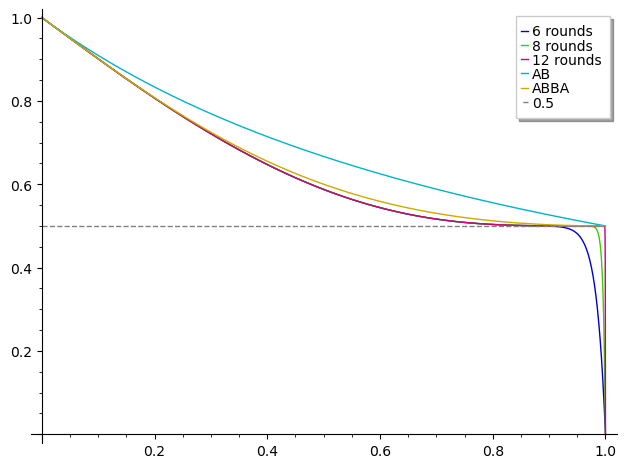

In [18]:
plot([A(i).simplify() for i in [6,8,12]]+[solve(eqn1,w)[0].rhs()(p=1-q),w_abba(p=1-q)],q,0,1,legend_label=["6 rounds","8 rounds","12 rounds","AB","ABBA"]) + plot(0.5,x,0,1,color="gray",linestyle="dashed",legend_label="0.5")

So as the chance of winning on a given roll goes down, as when the number of sides of the die goes up,
the chance that player A wins approaches 1/2 from above, and it takes more rounds before one player wins.
Player A has a greater advantage when the die has fewer sides.

In [19]:
[(i,numerical_approx(A(10)(q=(i-1)/i).simplify())) for i in [1..6]]

[(1, 1.00000000000000),
 (2, 0.587545966359892),
 (3, 0.523764883162973),
 (4, 0.508325222149083),
 (5, 0.503435397140515),
 (6, 0.501590339204269)]